In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/kaggle/input/solargeneration/dataset.csv')
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M')

In [2]:
# Feature engineering
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek

# Select features and target
features = ['temperature', 'Ground_radiation_intensity ', 'hour']
X = df[features]
y = df['Photovoltaic_power_generation']

In [3]:
# Split data (time-series split)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only (avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler

# Convert back to DataFrame for readability
X_train = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Initialize XGBoost Regressor with fixed parameters
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

# Fit on training data
xgb.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb.predict(X_test)

# Evaluate predictions
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\nDefault XGBoost Test Set Evaluation:")
print(f"MSE: {mse_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")




Default XGBoost Test Set Evaluation:
MSE: 212806.89
RMSE: 461.31
MAE: 289.04
R² Score: 0.83


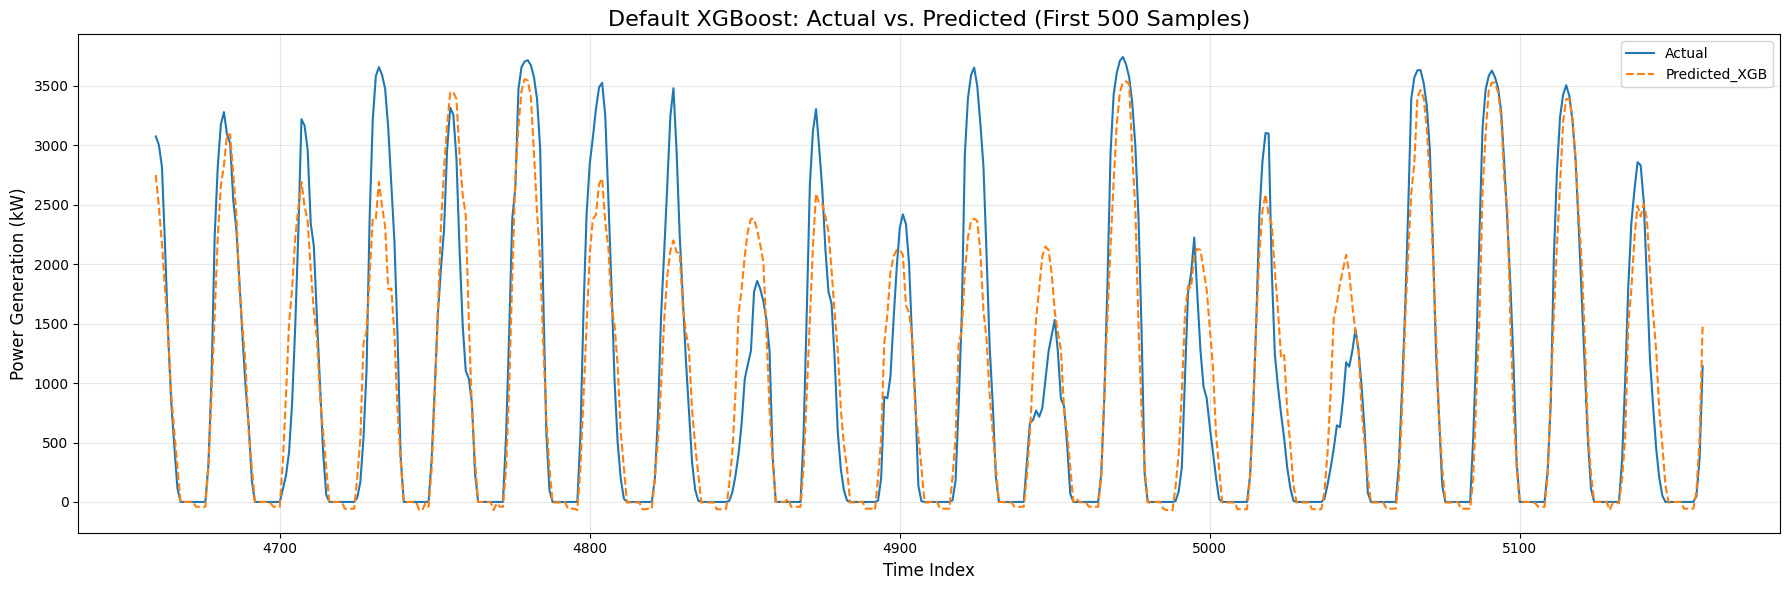

In [6]:
# Visualization
results_xgb = pd.DataFrame({
    'Actual': y_test,
    'Predicted_XGB': y_pred_xgb
}, index=y_test.index)

plt.figure(figsize=(18, 6))
results_xgb.head(500).plot(style=['-', '--'], ax=plt.gca())
plt.title("Default XGBoost: Actual vs. Predicted (First 500 Samples)", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Power Generation (kW)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost tuning
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# Initialize XGBoost regressor
xgb = XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1)

# Setup GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1, verbose=0)

In [9]:
# Fit on training data
grid_search_xgb.fit(X_train, y_train)

# Best estimator and parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_

# Predict on test set using best model
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate predictions
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\nTuned XGBoost Test Set Evaluation:")
print(f"MSE: {mse_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}

Tuned XGBoost Test Set Evaluation:
MSE: 200662.78
RMSE: 447.95
MAE: 274.40
R² Score: 0.84


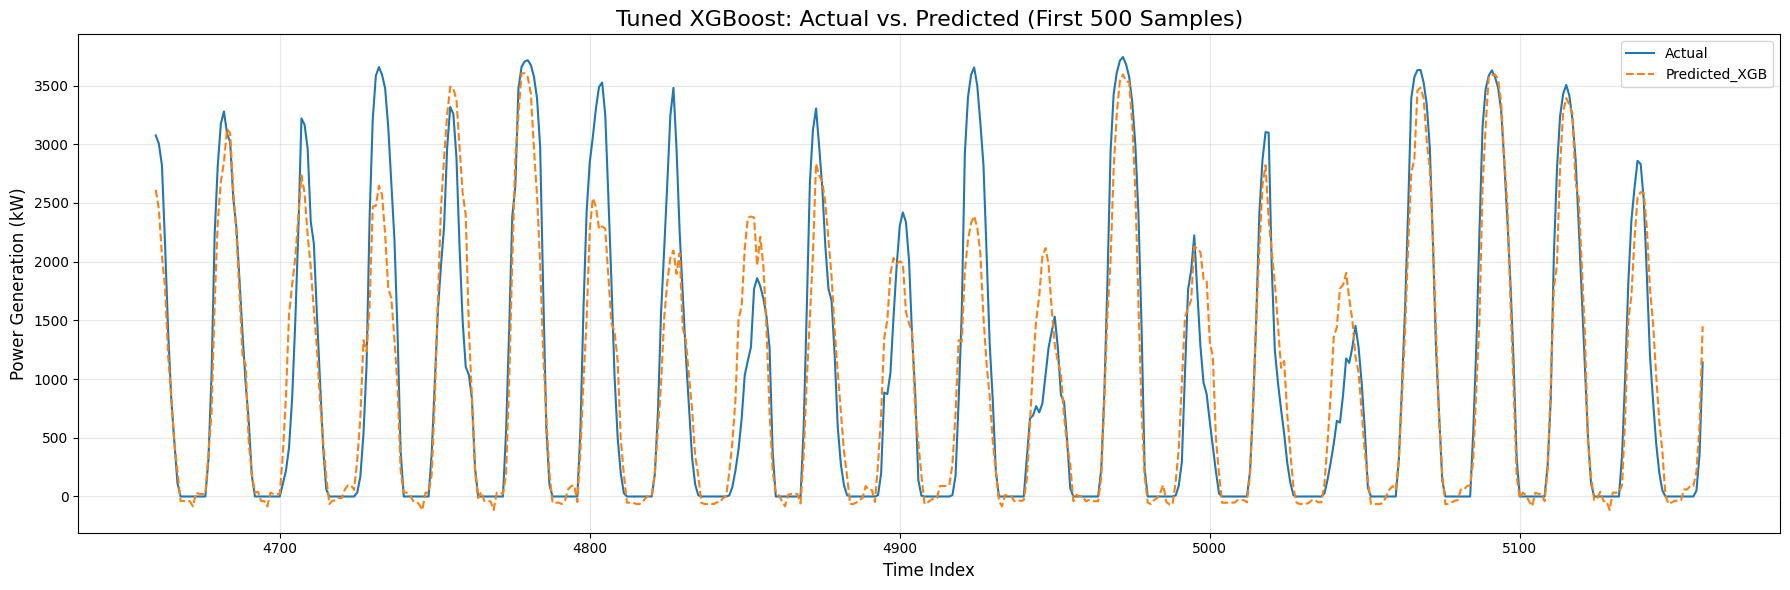

In [10]:
# Visualization
import matplotlib.pyplot as plt
results_xgb = pd.DataFrame({
    'Actual': y_test,
    'Predicted_XGB': y_pred_xgb
}, index=y_test.index)

plt.figure(figsize=(18, 6))
results_xgb.head(500).plot(style=['-', '--'], ax=plt.gca())
plt.title("Tuned XGBoost: Actual vs. Predicted (First 500 Samples)", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Power Generation (kW)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()